## Exercise 1

Implement a two-dimensional k-nearest neighbors classifier (in particular, do not use sklearn for k-nearest neighbors here): given a list of (x, y; class) data, store this data in a quad-tree (14 points). Given a new (x, y) point and a value of k (the number of nearest neighbors to examine), it should be able to identify the most common class within those k nearest neighbors (14 points). You may assume distance will be measured using the traditional euclidean distance.

Cinar and Koklu (2019) used various machine learning strategies to predict the type of rice based on image analysis. In this exercise, we'll do something similar.

Begin by going to the journal page and downloading the rice dataset (there's a dataset button on the right). Note that you can load data directly from the excel file via:

Normalize the seven quantitative columns to a mean of 0 and standard deviation 1. (3 points)

Reduce the data to two dimensions using PCA. You can do this with e.g.:

That is, pc0 can be thought of as a vector of x-values, pc1 as a vector of y-values, and data["CLASS"] as a vector of the corresponding types of rice.

Plot this on a scatterplot, color-coding by type of rice. (3 points)

Comment on what the graph suggests about the effeciveness of using k-nearest neighbors on this 2-dimensional reduction of the data to predict the type of rice. (4 points)

Using a reasonable train-test split with your k-nearest neighbors implementation, give the confusion matrix for predicting the type of rice with k=1. (4 points) Repeat for k=5. (4 points)

Provide a brief interpretation of what the confusion matrix results mean. (4 points)

Recall: All normalization must be based on the training set mean and standard deviation, not on data including the test set. Once the pca reduction has been trained, you can apply it to test data via, e.g.

(Note: we use .fit_transform with the training data and .transform with the test data.)

Hints:

 - The quad tree can construct itself from all the data by dividing into children if there's enough points for that to be reasonable, each one of which constructs itself recursively. Only the leaf nodes need to keep track of the points; the parent trees can just ask for all_points recursively.It's theoretically possible that you could have repeated x,y points... don't get stuck in an infinite loop
- If you're looking for the k nearest neighbors, to get your initial circle, stop descending if the child tree you'd go into doesn't have k points. (Alternatively, move up a level if you don't have enough points; you can do this easily if each tree knows its _parent.)
 - I have a method contains(self, x, y) which determines if the box of my tree's bounds (xlo, ylo, xhi, yhi) contains the given (x,y) point... this is used by a _within_distance(self, x, y, d) that returns true or false depending on if the point is within a distance d of the box. This is used by a recursive leaves_within_distance function that finds all of the leaves (i.e. the ones with no children) within a given distance of a point.
 - Once I had found the distances within my tree, to find the indices of the smallest k distances, I used the code: min_i = np.argpartition(distances, k)[:k]
 - When I did this, I tested it by making a function that directly checked all points to find the k-nearest points (you can do this in about 4 lines of code) and used that to have a known truth to help debug/validate the quad-tree-based solution.

## Response

In [665]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt
from sklearn import decomposition
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [666]:
dataset = pd.read_excel('/Users/mahimakaur/desktop/Rice_Cammeo_Osmancik.xlsx')

In [667]:
dataset.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


In [668]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   int64  
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   int64  
 6   Extent             3810 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 208.5 KB


In [669]:
##Creating a dataset without the last column

data = dataset.iloc[:,0:7]

In [670]:
##creating a dataset for the class column 

y = np.array(dataset.iloc[:,-1])

In [671]:
## Standardizing the dataset 

std_data = (data - data.mean())/data.std()

In [672]:
std_data.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03
mean,-2.124285e-16,-5.739940e-16,-1.181324e-16,-2.456478e-16,9.097418e-16,2.152259e-16,-4.754435e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.953604e+00,-2.672668e+00,-2.493699e+00,-4.674031e+00,-5.266589e+00,-2.942926e+00,-2.130034e+00
25%,-7.488177e-01,-7.892340e-01,-8.265593e-01,-6.251605e-01,-6.950351e-01,-7.463521e-01,-8.165818e-01
50%,-1.421335e-01,-1.513238e-01,-1.699936e-01,2.109949e-02,1.046992e-01,-1.384360e-01,-2.145634e-01
75%,7.401849e-01,8.271624e-01,8.467241e-01,6.684203e-01,7.550077e-01,7.493101e-01,8.367238e-01
max,3.605050e+00,2.646475e+00,2.878973e+00,3.704952e+00,2.936761e+00,3.458976e+00,2.577922e+00


In [673]:
## Reducing the data to two dimensions using PCA

PCA = decomposition.PCA(n_components=2)
data_reduced = PCA.fit_transform(std_data)
PC0 = data_reduced[:, 0]
PC1 = data_reduced[:, 1]

In [674]:
data_reduced

array([[ 3.81212784, -2.16504685],
       [ 2.47683257,  0.04529019],
       [ 2.63820924, -0.62153372],
       ...,
       [-0.43662669,  0.10358082],
       [-3.58746234, -0.37565233],
       [-2.55575212,  3.36079599]])

In [675]:
pc0 = PC0.tolist()
pc1 = PC1.tolist()
pca = pd.DataFrame({'PC0': pc0,'PC1': pc1,'Class': dataset['Class']})

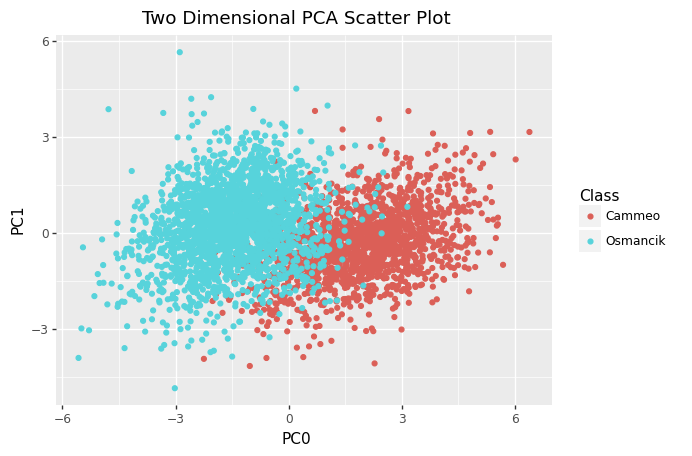

In [676]:
print (
    p9.ggplot(data = pca, mapping = p9.aes(x='PC0', y='PC1'))
 + p9.geom_point(p9.aes(x = 'PC0', y = 'PC1', color = 'Class'))
 + p9.labs(title = "Two Dimensional PCA Scatter Plot")
)

#### Comment on what the graph suggests about the effeciveness of using k-nearest neighbors on this 2-dimensional reduction of the data to predict the type of rice. 

We can somewhat see two clusters in the graphs, but there is no clear demarcation of the two clusters. The k-nearest neighbors might not an effective method to classify the data points. The region from -2 to 1 on the x-axis shows some overlap between the points of class "Cammeo" or "Osmancik" which can lead to inaccurate prediction of the type of rice.  

### Implementation of the KNN algorithm and Quad Tree

Citations :
- https://katherinepully.com/quadtree-python/
- https://www.geeksforgeeks.org/quad-tree/

Contructing a quadtree from a two-dimensional area using the following steps:

1.Divide the current two dimensional space into four boxes.<br>
2.If a box contains one or more points in it, create a child object, storing in it the two dimensional space of the box. <br>
3.If a box does not contain any points, do not create a child for it. <br>
4.Recurse for each of the children.

In [677]:
indices = [i for i in range(len(PC0))]
data_knn = np.array([PC0,PC1,indices])

In [678]:
data_knn

array([[ 3.81212784e+00,  2.47683257e+00,  2.63820924e+00, ...,
        -4.36626685e-01, -3.58746234e+00, -2.55575212e+00],
       [-2.16504685e+00,  4.52901938e-02, -6.21533719e-01, ...,
         1.03580824e-01, -3.75652326e-01,  3.36079599e+00],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00, ...,
         3.80700000e+03,  3.80800000e+03,  3.80900000e+03]])

In [679]:

class QTree:

    def __init__(self,bounding_box,data,height = 0,max_leaf_data = 3):
      
    
        self.xlo = min(bounding_box[0][0],bounding_box[1][0],bounding_box[2][0],bounding_box[3][0])
        self.xhi = max(bounding_box[0][0],bounding_box[1][0],bounding_box[2][0],bounding_box[3][0])
        self.ylo = min(bounding_box[0][1],bounding_box[1][1],bounding_box[2][1],bounding_box[3][1])
        self.yhi = max(bounding_box[0][1],bounding_box[1][1],bounding_box[2][1],bounding_box[3][1])
        self.leafNode = False
        self.height = height
        self.points = []
        self.add(data)
        self.numPoints = len(self.points[0])
        
        if(self.numPoints<= max_leaf_data):
            self.leafNode = True
            return
        

        self.x_median = np.median(self.points[0])
        self.y_median = np.median(self.points[1])

        
        bounding_box_ul = [bounding_box[0],(self.xlo,self.y_median),(self.x_median,self.yhi),(self.x_median,self.y_median)]
        bounding_box_lr = [(self.x_median,self.y_median),(self.x_median,self.ylo),(self.xhi,self.y_median),bounding_box[3]]
        bounding_box_ll = [(self.xlo,self.y_median),bounding_box[1],(self.x_median,self.y_median),(self.x_median,self.ylo)]
        bounding_box_ur = [(self.x_median,self.yhi),(self.x_median,self.y_median),bounding_box[2],(self.xhi,self.y_median)]
        self.URChild = QTree(bounding_box_ur,self.points,height = self.height + 1,max_leaf_data = max_leaf_data)
        self.LRChild = QTree(bounding_box_lr,self.points,height = self.height + 1,max_leaf_data = max_leaf_data)
        self.ULChild = QTree(bounding_box_ul,self.points,height = self.height + 1,max_leaf_data = max_leaf_data)
        self.LLChild = QTree(bounding_box_ll,self.points,height = self.height + 1,max_leaf_data = max_leaf_data)
        self.children = [self.ULChild,self.LLChild,self.URChild,self.LRChild]

        if(self.leafNode == False):
            del self.points

    def contains(self,x,y):    
        if((self.xlo <= x) and (x < self.xhi) and (self.ylo <= y) and (y < self.yhi)):
            return True
        return False

    def add(self,data):
        points_x = []
        points_y = []
        points_indices = []
        for i in range(0,len(data[0])):
            
            if(self.contains(data[0][i],data[1][i])):
                points_x.append(data[0][i])
                points_y.append(data[1][i])
                points_indices.append(data[2][i])
        
        self.points = np.array([points_x,points_y,points_indices],dtype = float)
    
    def getPoints(self):
        if(self.leafNode):
            return self.points
        
        return np.concatenate((self.ULChild.getPoints(),self.LLChild.getPoints(),self.URChild.getPoints(),self.LRChild.getPoints()),axis = 1)
    
    def Distance(self,x,y,xp,yp):
        return np.linalg.norm((x-xp,y-yp))
    
    def getHeight(self):
        if(self.leafNode):
            return self.height
        return max(self.ULChild.getHeight(),self.LLChild.getHeight(),self.URChild.getHeight(),self.LRChild.getHeight())
        
        
    def BBox(self,d,x,y):
        if(self.contains(x,y)):
            return True
        if(x<=self.xlo):
            if(y<=self.ylo):
                d_first = self.Distance(x,y,self.xlo,self.ylo)
                if(d_first<=d):
                    return True
            elif(y>=self.yhi):
                d_first = self.Distance(x,y,self.xlo,self.yhi)
                if(d_first<=d):
                    return True
            else:
                d_first = self.Distance(x,y,self.xlo,y)
                if(d_first<=d):
                    return True

        elif(x>self.xhi):
            if(y<=self.ylo):
                d_first = self.Distance(x,y,self.xhi,self.ylo)
                if(d_first<=d):
                    return True
            elif(y>=self.yhi):
                d_first = self.Distance(x,y,self.xhi,self.yhi)
                if(d_first<=d):
                    return True
            else:
                d_first = self.Distance(x,y,self.xhi,y)
                if(d_first<=d):
                    return True

        else:
            if(y<=self.ylo):
                d_first = self.Distance(x,y,x,self.ylo)
                if(d_first<=d):
                    return True
            elif(y>=self.ylo):
                d_first = self.Distance(x,y,x,self.yhi)
                if(d_first<=d):
                    return True

        return False
    

    def within_distance(self,d,x,y):
        if(self.leafNode):
            if(self.BBox(d,x,y)):
                return self.points
            else:
                return np.array([[],[],[]])
        return np.concatenate((self.ULChild.within_distance(d,x,y),self.LLChild.within_distance(d,x,y),self.URChild.within_distance(d,x,y),self.LRChild.within_distance(d,x,y)),axis = 1)
    
    def get_data_in_range(self,k,x,y):
        if(self.leafNode):
            return self
       
        
        for child in self.children:
            if(child.contains(x,y)):
                if(child.numPoints>=k):
                    return child.get_data_in_range(k,x,y)
                else:
                    return self


In [680]:
def getQuadTree(data_knn,max_leaf_data = 3):
    xlo = min(data_knn[0]) - 2
    xhi= max(data_knn[0]) + 2
    ylo = min(data_knn[1]) - 2
    yhi = max(data_knn[1]) + 2
    bounding_box = [(xlo,yhi),(xlo,ylo),(xhi,yhi),(xhi,ylo)]
    q1 = QTree(bounding_box,data_knn,height = 0,max_leaf_data=max_leaf_data)
    return q1

### Implementing k nearest neighbors using QuadTree

- Step 1 : Determine parameter k = number of nearest neighbors
- Step 2 : Calculate the distance between the query-instance and all the training samples (The most commonly used method to calculate distance is Euclidean)
- Step 3 : Sort the distance and determine the nearest neighbors based on the kth minimum distance 
- Step 4 : Gather the category Y of the nearest neighbors
- Step 5 : Use majority voting of the category of the nearest neighnors as the prediction value.


Reference : 
- https://serokell.io/blog/knn-algorithm-in-ml
- https://people.revoledu.com/kardi/tutorial/KNN/KNN_Numerical-example.html
-https://www.tutorialspoint.com/machine_learning_with_python/machine_learning_with_python_knn_algorithm_finding_nearest_neighbors.htm

numpy.argpartition() function is used to create a indirect partitioned copy of input array with its elements rearranged in such a way that the value of the element in k-th position is in the position it would be in a sorted array. All elements smaller than the k-th element are moved before this element and all equal or greater are moved behind it (https://www.geeksforgeeks.org/numpy-argpartition-in-python/)

In [681]:
def knn_quad(k,x,y,quadtree):
    BoundingBox = quadtree.get_data_in_range(k,x,y)
    points =  BoundingBox.getPoints()
    Euclideandistance = []
   
    for i in range(len(points[0])):
        dist = BoundingBox.Distance(x,y,points[0][i],points[1][i])
        Euclideandistance.append(dist)
    k_smallest_indices = np.argpartition(Euclideandistance, k-1)[:k]
   
  
    kth_dist = Euclideandistance[k_smallest_indices[-1]]
    points2 = quadtree.within_distance(kth_dist,x,y)
    Euclideandistance2 = []
    
    for j in range(len(points2[0])):
        dist = BoundingBox.Distance(x,y,points2[0][j],points2[1][j])
        Euclideandistance2.append(dist)
    k_smallest_indices_2 = np.argpartition(Euclideandistance2, k-1)[:k]
    value = [points2[:,i] for i in k_smallest_indices_2]
    return value

In [682]:
def get_Indices(arr_points):
    indices_arr = []
    for i in range(len(arr_points)):
        indices_arr.append(int(arr_points[i][2]))
    return np.array(indices_arr,dtype = int)

In [683]:
def knn_points(k,known_neighbors,x,y):
    test_neighbors = np.array([[x,y]])
    Euclideandistance = []

    for i in range(len(known_neighbors[0])):
        neighbors = known_neighbors[:,i]
      
        Euclideandistance.append(np.linalg.norm(test_neighbors - neighbors))
    
    
    k_smallest_indices = np.argpartition(Euclideandistance, k)[:k]
    return k_smallest_indices,Euclideandistance

#### Creating a function to get majority vote as For classification: A class label assigned to the majority of K Nearest Neighbors from the training dataset is considered as a predicted class for the new data point. 

Reference : https://www.analyticsvidhya.com/blog/2021/04/simple-understanding-and-implementation-of-knn-algorithm/

In [684]:
def majority_vote(y):
    values,counts = np.unique(y,return_counts=True)
    indices = np.argmax(counts)
    return values[indices]

### Reasonable train-test split 

If the dataset is relatively small (n < 10,000), 70:30 would be a suitable choice.

However, for smaller datasets (n < 1,000), each observation is extremely valuable, and we can’t spare any for validation. In this case, k-fold cross-validation is a better choice than the holdout method. This method is computationally expensive. Yet it offers an effective model evaluation over a small dataset by training multiple models.

Reference : https://www.baeldung.com/cs/train-test-datasets-ratio


### Confusion Matrix when k = 1 or k = 5 using k-fold cross-validation

Cross Validation is the procedure which has a single parameter called k that refers to the number of groups that a given data sample is to be split into. The value for k is chosen such that each train/test group of data samples is large enough to be statistically representative of the broader dataset. The choice of k is usually 5 or 10, but there is no formal rule. Cross-validation gives the model an opportunity to test on multiple splits so we can get a better idea on how the model will perform on unseen data.


Cross Validation Citation : https://towardsdatascience.com/cross-validation-using-knn-6babb6e619c8

#### Confusion Matrix when k = 1 using k-fold cross-validation

The confusion matrix when k =1 is:


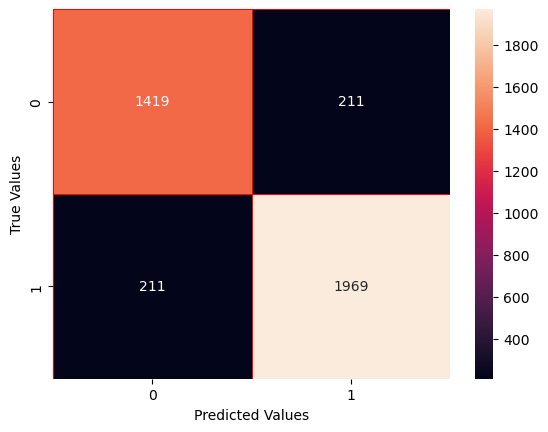

Classification Report:
              precision    recall  f1-score   support

      Cammeo       0.87      0.87      0.87      1630
    Osmancik       0.90      0.90      0.90      2180

    accuracy                           0.89      3810
   macro avg       0.89      0.89      0.89      3810
weighted avg       0.89      0.89      0.89      3810

Accuracy Score:
0.8892388451443569


In [685]:
pca = decomposition.PCA(n_components=2)
kfold = KFold(10,shuffle = True,random_state = 1)
scaler = StandardScaler()
counter = 0

Value_Pred = []
Value_True = []
First_Value = []

for train,test in (kfold.split(data_knn[2])):
    X_train_raw = dataset.iloc[train,0:7]
    X_test_raw = dataset.iloc[test,0:7]
    scaler.fit(X_train_raw)
    X_train_std = scaler.transform(X_train_raw)
    X_test_std = scaler.transform(X_test_raw)
    train_data_reduced = pca.fit_transform(X_train_std)
    test_data_reduced = pca.transform(X_test_std)
    train_data = np.array([train_data_reduced[:,0],train_data_reduced[:,1],train])
    test_data = np.array([test_data_reduced[:,0],test_data_reduced[:,1],test])
    
    quad_train = getQuadTree(train_data)
    
    for i in test:
        
        value_1 = knn_quad(1,test_data[0,test_data[2] == i],test_data[1,test_data[2] == i],quad_train)
        First_Value.append(value_1)
        k_smallest_indices = get_Indices(value_1)
        y_points = y[k_smallest_indices]
        value_pred = majority_vote(y_points)
        value_true = y[i]
        Value_Pred.append(value_pred)
        Value_True.append(value_true)
        
    
    counter+=1
    
print("The confusion matrix when k =1 is:")
cm = confusion_matrix(Value_True,Value_Pred)
sns.heatmap(cm,annot=True, linewidths= 0.5, linecolor="red", fmt=".0f")  
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()
print("Classification Report:")
print(classification_report(Value_True,Value_Pred))
print("Accuracy Score:")
print(accuracy_score(Value_True,Value_Pred))

#### Confusion Matrix when k = 5 using k-fold cross-validation

The confusion matrix when k = 5 is:


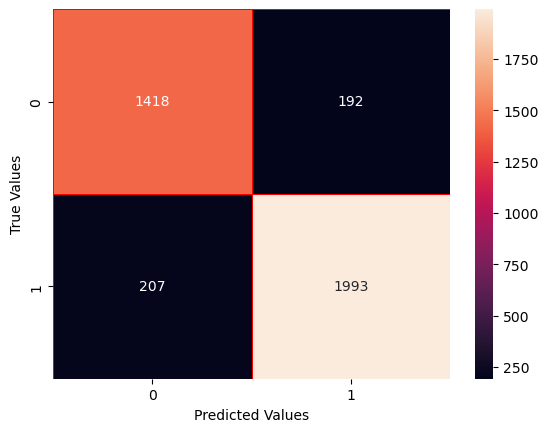

Classification Report:
              precision    recall  f1-score   support

      Cammeo       0.87      0.88      0.88      1610
    Osmancik       0.91      0.91      0.91      2200

    accuracy                           0.90      3810
   macro avg       0.89      0.89      0.89      3810
weighted avg       0.90      0.90      0.90      3810

Accuracy Score:
0.8952755905511811


In [686]:
pca = decomposition.PCA(n_components=2)
kfold = KFold(10,shuffle = True,random_state = 1)
scaler = StandardScaler()
counter = 0

Value_Pred = []
Value_True = []
First_Value = []

for train_index,test_index in (kfold.split(data_knn[2])):
    X_train_raw = dataset.iloc[train_index,0:7]
    X_test_raw = dataset.iloc[test_index,0:7]
    scaler.fit(X_train_raw)
    X_train_std = scaler.transform(X_train_raw)
    X_test_std = scaler.transform(X_test_raw)
    train_data_reduced = pca.fit_transform(X_train_std)
    test_data_reduced = pca.transform(X_test_std)
    train_data = np.array([train_data_reduced[:,0],train_data_reduced[:,1],train])
    test_data = np.array([test_data_reduced[:,0],test_data_reduced[:,1],test])
    
    quad_train = getQuadTree(train_data)
    
    for i in test:
        
        value_5 = knn_quad(5,test_data[0,test_data[2] == i],test_data[1,test_data[2] == i],quad_train)
        First_Value.append(value_5)
        k_smallest_indices = get_Indices(value_5)
        y_points = y[k_smallest_indices]
        value_pred = majority_vote(y_points)
        value_true = y[i]
        Value_Pred.append(value_pred)
        Value_True.append(value_true)
        
    
    counter+=1
    
print("The confusion matrix when k = 5 is:")
cm = confusion_matrix(Value_True,Value_Pred)
sns.heatmap(cm,annot=True, linewidths= 0.5, linecolor="red", fmt=".0f")  
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()
print("Classification Report:")
print(classification_report(Value_True,Value_Pred))
print("Accuracy Score:")
print(accuracy_score(Value_True,Value_Pred))

#### Brief interpretation of what the confusion matrix results mean.

Confusion Matrix is a method of summarizing a classification algorithm’s performance. It is simply a summarized table of the number of correct and incorrect predictions. Calculating a confusion matrix can give us a better idea about the miss-classified classes. It is a square matrix where the column reflects actual values and the row represents the model’s predicted value or vice versa. rows show actual values and columns indicate predicted values. 

- TP = A true positive is an outcome where the model correctly predicts the positive class.
- FP = The model predicted True and it is false.
- TN = The model predicted false and it is false.
- FN = The model predicted false and it is true.

When k = 1, the confusion matrix is (1419 211 211 1969). We can see that 1630 out of 1419 true classes were classified correctly i.e the model classified the type of rice as the data itself (TP). At the same time, 211 of them were placed incorrectly (FP), and 2180 out of 1969 false classes were classified correctly (TN), while 211 of them were misclassified (FN). The accuracy score of the model is 88.9%. 

When k = 5, the confusion matrix is (1418 192 207 1993). We can see that 1610 out of 1418 true classes were classified correctly i.e the model classified the type of rice as the data itself (TP). At the same time, 192 of them were placed incorrectly (FP), and 2200 out of 1993 false classes were classified correctly (TN), while 207 of them were misclassified (FN). The accuracy score of the model is 89.5%. 

Insights :
- As k increases the the accuracy of the model increases. 
- The precision of clasiifying Rice Type : Osmancik is more than Cammeo in both the models. 

#### Confusion matrix for predicting the type of rice with k=1 using train-test split - Using pre-existing library

In [687]:
X = dataset.iloc[:,0:7]

In [688]:
y = dataset['Class']

In [689]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train1 = scaler.transform(X_train)
X_test1 = scaler.transform(X_test)

In [690]:
PCA = decomposition.PCA(n_components=2)

In [691]:
X_train = PCA.fit_transform(X_train1)

In [692]:
X_test = PCA.transform(X_test1)

In [693]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [694]:
classifier = KNeighborsClassifier(n_neighbors = 1)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [695]:
y_pred = classifier.predict(X_test)

In [696]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Confusion Matrix:
[[ 658  123]
 [ 113 1011]]
Classification Report:
              precision    recall  f1-score   support

      Cammeo       0.85      0.84      0.85       781
    Osmancik       0.89      0.90      0.90      1124

    accuracy                           0.88      1905
   macro avg       0.87      0.87      0.87      1905
weighted avg       0.88      0.88      0.88      1905

Accuracy: 0.8761154855643044


#### Confusion matrix for predicting the type of rice with k=5 using train-test split.

In [697]:
X = dataset.iloc[:,0:7]

In [698]:
y = np.array(dataset.iloc[:,-1])

In [699]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [700]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [701]:
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [702]:
y_pred = classifier.predict(X_test)

In [703]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Confusion Matrix:
[[588  61]
 [ 68 807]]
Classification Report:
              precision    recall  f1-score   support

      Cammeo       0.90      0.91      0.90       649
    Osmancik       0.93      0.92      0.93       875

    accuracy                           0.92      1524
   macro avg       0.91      0.91      0.91      1524
weighted avg       0.92      0.92      0.92      1524

Accuracy: 0.9153543307086615
